In [17]:
import torch
from torchmetrics import ConfusionMatrix
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
from torchvision import datasets, transforms
import timm
from torchinfo import summary

import sys
from pathlib import Path
import os

sys.path.append("../")

import random
import json
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from src.classification.evaluate import predictions
from src.classification.model import model
from src.data.generate_lego_part_classes import get_part_classes
from src.common import tools

from typing import Any, List, Union, Callable, Optional, Tuple

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
# Set path to data
data_path = Path("../data/classification")

part_class_path: Path = Path("../src/data/parts.csv")

image_paths: list[Path] = []
for root, dirs, _ in os.walk(data_path):
    for dir_name in dirs:
        folder_path: str = os.path.join(root, dir_name)
        subfolder_contents: list[str] = os.listdir(folder_path)

        if all(
            os.path.isfile(os.path.join(folder_path, item))
            for item in subfolder_contents
        ):
            image_paths.append(Path(root))
            break

cust_img_path = Path("C:/Users/chris/Documents/Images/lego/cropped_images")

image_path_list = list(itertools.chain.from_iterable([list(img_path.glob("*/*.jpg")) for img_path in image_paths]))
cust_img_path_list = list(cust_img_path.glob("*/*.jpg"))

image_paths, cust_img_path

([WindowsPath('../data/classification/b200c-lego-classification-dataset'),
  WindowsPath('../data/classification/real_image_dataset/Bars Ladders and Fences'),
  WindowsPath('../data/classification/real_image_dataset/Bionicle Hero Factory and Constraction'),
  WindowsPath('../data/classification/real_image_dataset/Bricks'),
  WindowsPath('../data/classification/real_image_dataset/Bricks Curved'),
  WindowsPath('../data/classification/real_image_dataset/Bricks Round and Cones'),
  WindowsPath('../data/classification/real_image_dataset/Bricks Sloped'),
  WindowsPath('../data/classification/real_image_dataset/Bricks Special'),
  WindowsPath('../data/classification/real_image_dataset/Bricks Wedged'),
  WindowsPath('../data/classification/real_image_dataset/Hinges Arms and Turntables'),
  WindowsPath('../data/classification/real_image_dataset/Minifig Accessories'),
  WindowsPath('../data/classification/real_image_dataset/Panels'),
  WindowsPath('../data/classification/real_image_dataset/Plan

In [20]:
# Creating file with part id classes if not already created
part_ids = sorted(
    set([part for img_path in image_paths for part in os.listdir(img_path)])
)
class_names = []

class_dict = tools.part_cat_csv_to_dict(part_class_path)
for id in part_ids:
    part_class = str(tools.get_part_cat(part_id=id, id_to_cat=class_dict))
    if part_class not in class_names:
        class_names.append(part_class)
class_names = sorted(class_names, key=lambda x: int(x))

In [58]:
effnet_sorter, image_transform = model.timm_create_model(model_name="efficientnet_b0", class_names=class_names, device=device)
state_dict = torch.load(f="../models/classification/timm_models/timm_effnet_b0_lego_sorterV0.pt")
state_dict["classifier.weight"] = state_dict.pop("classifier.1.weight")
state_dict["classifier.bias"] = state_dict.pop("classifier.1.bias")

effnet_sorter.load_state_dict(state_dict, strict=False)

#effnet_sorter, weights = model.create_efficientnet_b0(class_names=class_names, device=device)
#image_transform = weights.transforms()
#effnet_sorter.load_state_dict(torch.load(f="../models/classification/batch_1/efficientnet_b0_lego_sorter.pt"))



C:\Users\chris\AppData\Local\Temp\ipykernel_25532\3619017371.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f="../models/classification/timm_mod

<All keys matched successfully>

In [35]:
summary(model=effnet_sorter, 
        input_size=(64, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                        [64, 3, 224, 224]    [64, 37]             --                   True
├─Conv2d (conv_stem)                               [64, 3, 224, 224]    [64, 32, 112, 112]   864                  True
├─BatchNormAct2d (bn1)                             [64, 32, 112, 112]   [64, 32, 112, 112]   64                   True
│    └─Identity (drop)                             [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─SiLU (act)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
├─Sequential (blocks)                              [64, 32, 112, 112]   [64, 320, 7, 7]      --                   True
│    └─Sequential (0)                              [64, 32, 112, 112]   [64, 16, 112, 112]   --                   True
│    │    └─DepthwiseSeparableConv (0)         

In [36]:
image_transform

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [37]:
IMG_EXTENSIONS = (
    ".jpg",
    ".jpeg",
    ".png",
    ".ppm",
    ".bmp",
    ".pgm",
    ".tif",
    ".tiff",
    ".webp",
)

# Custom Dataset class for altering the labels of the dataset
class PartSortingDataset(datasets.DatasetFolder):
    def __init__(
        self,
        root: Union[str, Path],
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = datasets.folder.default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        allow_empty: bool = False,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
            allow_empty=allow_empty,
        )
        self.imgs = self.samples

        if self.target_transform is not None:
            transformed_classes = set(sorted(self.target_transform(_class) for _class in self.classes))
            transformed_to_idx = {transformed: idx for idx, transformed in enumerate(transformed_classes)}
            target_to_transformed = {self.class_to_idx[target]: transformed_to_idx[self.target_transform(target)] for target in self.classes}

            self.transformed_classes = transformed_classes
            self.transformed_to_idx = transformed_to_idx
            self.target_to_transformed = target_to_transformed

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """

        class_to_idx = self.class_to_idx
        target_to_transformed = self.target_to_transformed

        path, target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = target_to_transformed[target]

        return sample, target

    def __len__(self) -> int:
        return len(self.imgs)


In [38]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform = None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [39]:
# Make data folder into dataset
def target_transform(target):
    return tools.get_part_cat(target, class_dict)

independent_datasets: list[PartSortingDataset] = []
for path in image_paths:
    independent_datasets.append(
        PartSortingDataset(
            root=path, target_transform=target_transform
        )
    )

full_dataset = ConcatDataset(independent_datasets)

print(f"Dataset length: {len(full_dataset)}")

sample, label = full_dataset[0]  # Access the first sample
print(f"Sample size: {sample}, Label: {label}")

Dataset length: 1497613
Sample size: <PIL.Image.Image image mode=RGB size=64x64 at 0x1D040020D30>, Label: 4


In [40]:
# Split into training and testing data
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_set, test_set = random_split(full_dataset, [train_size, test_size])

train_data = DatasetFromSubset(train_set, image_transform)
test_data = DatasetFromSubset(test_set, image_transform)

print(f"{len(train_data)}\n{len(test_data)}")

1198090
299523


In [41]:
sample, label = train_data[0]  # Access the first sample
print(f"Sample size: {sample.size()}, Label: {label}")

Sample size: torch.Size([3, 224, 224]), Label: 12


In [42]:
BATCH_SIZE = 256
NUM_WORKERS = 0
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Make dataset into dataloader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

Creating DataLoader's with batch size 256 and 0 workers.


(4681, 1171)

In [43]:
train_dataloader.dataset.transform

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [44]:
transformed_to_idx = {}
idx_to_transformed = {}

for d_set in full_dataset.datasets:
    transformed_to_idx.update(d_set.transformed_to_idx)
    idx_to_transformed.update({idx: trans for trans, idx in d_set.transformed_to_idx.items()})

list(idx_to_transformed.values())

[3,
 5,
 6,
 8,
 9,
 11,
 12,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 32,
 35,
 36,
 37,
 40,
 41,
 46,
 47,
 49,
 51,
 52,
 53,
 54,
 55,
 67]

In [45]:
def pred_image(
    model: torch.nn.Module,
    image_path: Union[Path, str],
    image_size: Tuple[int, int] = (224, 224),
    transform: Union[transforms.Compose, None] = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    return target_image_pred_label

In [46]:
preds = []

img_iters = image_path_list
random.shuffle(img_iters)

for path in tqdm(img_iters[:1000]):
    y_pred = pred_image(model=effnet_sorter,
                    image_path=path,
                    transform=image_transform)
    y_pred_class = int(class_names[y_pred])
    target_class = int(tools.get_part_cat(str(path.parent.name), class_dict))

    preds.append(1 if y_pred_class == target_class else 0)

acc = sum(preds) / len(preds)

acc

100%|██████████| 1000/1000 [00:20<00:00, 48.84it/s]


0.495

In [47]:
# Predict on a target image with a target model
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[int],
    image_path: Union[Path, str],
    image_size: Tuple[int, int] = (224, 224),
    transform: transforms.Compose | None = None,
    device: torch.device = device,
) -> None:
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    runner_up_target_image_pred_label = torch.argsort(
        target_image_pred_probs, dim=1, descending=True
    )[:, 1]

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(transformed_image.squeeze().permute(2, 1, 0))
    plt.title(
        f"1. | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}\n"
        f"2. | Pred: {class_names[runner_up_target_image_pred_label]} | Prob: {target_image_pred_probs.topk(2, dim=1).values[:, 1].item():.3f}"
    )
    plt.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.12535..2.64].


Correct class:  67


WindowsPath('../data/classification/b200c-lego-classification-dataset/27925/3700.jpg')

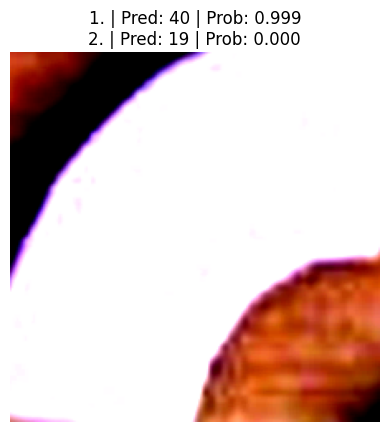

In [56]:
random_image_path: Path = random.choice(image_path_list)
pred_and_plot_image(model=effnet_sorter,
                    class_names=class_names,
                    image_path=random_image_path,
                    transform=image_transform)
target_class = tools.get_part_cat(str(random_image_path.parent.name), class_dict)
print(f"Correct class:  {target_class}")

random_image_path

In [13]:
# 1. Make predictions with trained model
y_preds = []
effnet_sorter.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):

    X, y = X.to(device), y.to(device)

    y_logit = effnet_sorter(X)
    
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   1%|          | 7/1171 [00:13<36:26,  1.88s/it]


KeyboardInterrupt: 

In [14]:
test_targets = torch.tensor([class_names[label] for _, label in tqdm(test_data)])

test_targets

 34%|███▍      | 101640/299523 [09:23<18:17, 180.31it/s]


KeyboardInterrupt: 

In [49]:
conv_y_pred_tensor = torch.tensor([int(class_names[idx]) for idx in y_pred_tensor.tolist()])
conv_y_pred_tensor

tensor([23, 14, 40,  ..., 28, 12,  9])

In [70]:
len(set(torch.unique(test_targets).tolist()))

37

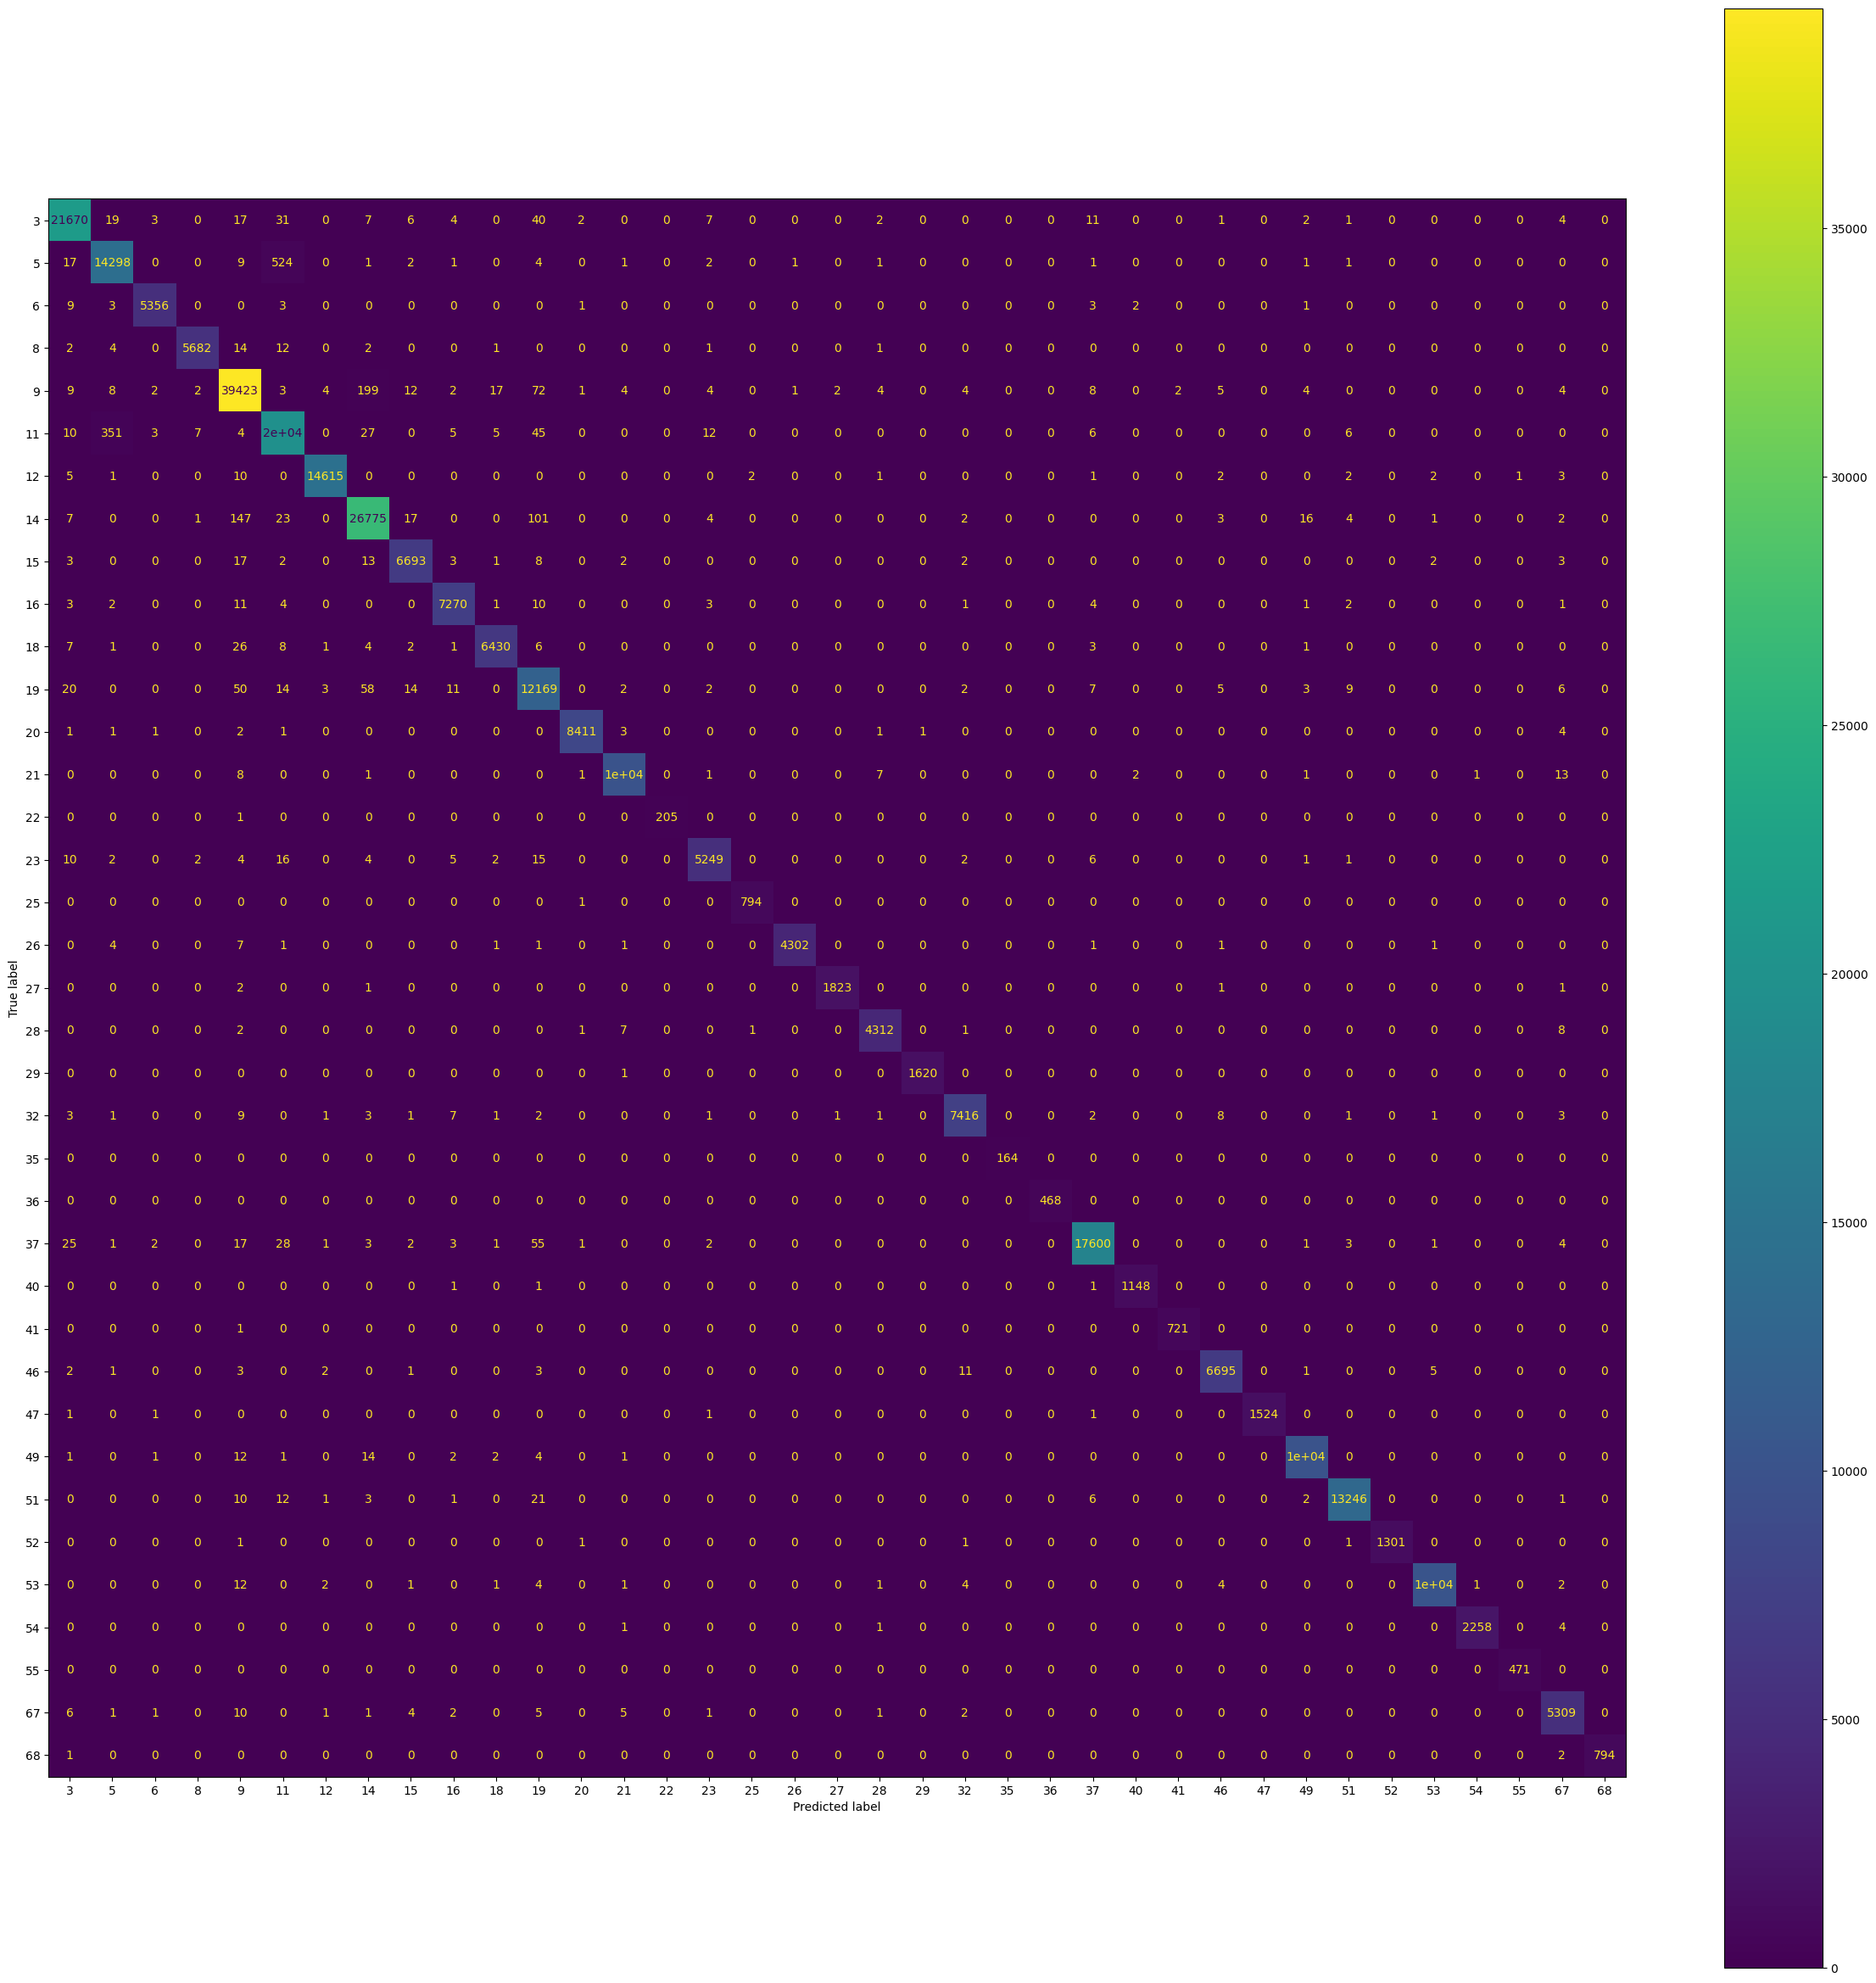

In [74]:
# Print a confusion matrix
cm = confusion_matrix(test_targets, conv_y_pred_tensor)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(torch.unique(test_targets).tolist()))

fig, ax = plt.subplots(figsize=(30, 30))
cmp.plot(ax=ax)